# Assignment 5: Principal Components Analysis
## Christopher Rico
## MSDS 422

You will compete in the Kaggle.com Digit Recognizer competition which involves classical digit recognition from hand-written images https://www.kaggle.com/c/digit-recognizer/

Read the competition rules, and download the MNIST training and test set data.This binary classification task is NOT what is required for the current assignment. In this assignment we are asking for a multiclass classifier. The entire MNIST data set will be used for input data. For this assignment, you will develop a classifier that may be used to predict which of the 10 digits is being written.  

Scikit Learn documentation for this assignment:


*   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
*   https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
*   https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html#sphx-glr-auto-examples-classification-plot-digits-classification-py
*   https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html




---





# Ingest

Environment Setup

In [0]:
#--------------------------------------------------------------------
#                       Dev Environment Setup
#--------------------------------------------------------------------

# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 42

# import base packages into the namespace for this program

from google.colab import files
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from math import sqrt  # for root mean-squared error calculation

# modeling routines from Scikit Learn packages
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

Utility functions for displaying images

In [0]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")


def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

Getting and Examining Data

In [0]:
#--------------------------------------------------------------------
#                     Getting and Examining Data
#--------------------------------------------------------------------

# Adapted from https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab
# Run this cell and select the kaggle.json file
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"christophrico","key":"950c6f1b242d7d9159426efd8bd9cdcb"}'}

In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
#now download the MNIST datasets using the kaggle API
!kaggle competitions download -c digit-recognizer

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
#and get them both into dataframes
train_data = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')

In [0]:
train_data.dropna()
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
X_test.dropna()
X_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
#split training set into X and y.


X_train.shape

(42000, 784)

In [0]:
y_train.shape

(42000,)

# EDA


---



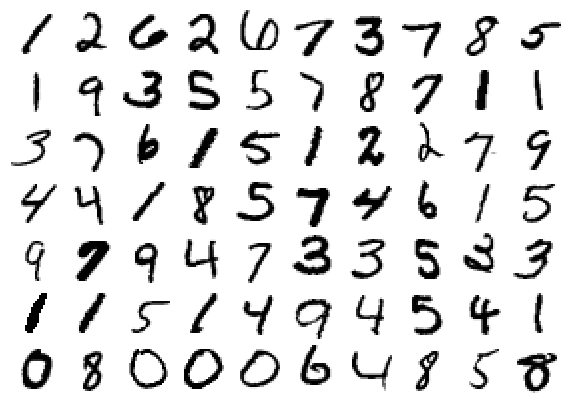

In [0]:
# let's have a look at some of the handwritten digits
plt.figure(figsize=(10,10))
sample_pics = np.r_[X_train[:12000:600],
                    X_train[13000:30600:600],
                    X_train[30600:60000:590]]
plot_digits(sample_pics, images_per_row=10)
plt.show()

# Modeling


---



CSV file saver

In [0]:
# utility function to output predictions to kaggle formatted csv
def pred_output(filename, preds):
  #create the output file
  rf_out = open(filename, "w")
  rf_out.write("ImageId,Label\n")

  #save the predictions to it
  index = 1
  for prediction in preds:
    rf_out.write( "{},{}\n".format(index, prediction) )
    index += 1

  #close the file and download it
  rf_out.close()
  files.download(filename)

In [0]:
# make a dataframe to store results in
time_results = pd.DataFrame(columns=['Classifier', 'Time to Fit'])

### 1: Random Forest Classifier

In [0]:
# time the random forest classifier fit on all training set params
rf = RandomForestClassifier(
                            bootstrap=True,
                            n_estimators=10,
                            max_features=28,
                            random_state=RANDOM_SEED,
                           )

#time fitting and evaluating the model
start = datetime.now()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
end = datetime.now()

time_results = time_results.append({'Classifier' : 'RFC',
                                    'Time to Fit' : end-start},
                                    sort=False,
                                    ignore_index=True)

print(end-start)

0:00:04.395318


In [0]:
# now output the predictions
pred_output("rf_predictions.csv", rf_pred)

### 2: Principal Component Analysis

In [0]:
#concatenate the train and test datasets together to do PCA
X_train_test = pd.concat([train_data.loc[:,'pixel0':], X_test], axis=0)
X_train_test.shape

(70000, 784)

In [0]:
#now we set up the PCA for a run and time it
pca = PCA(
          n_components=0.95,
          random_state=RANDOM_SEED
         )

#time identifying the PC's
start = datetime.now()
X_train_test_pca = pca.fit_transform(X_train_test)
end = datetime.now()

time_results = time_results.append({'Classifier' : 'PCA',
                                    'Time to Fit' : end-start},                                    
                                    sort=False,
                                    ignore_index=True)

print(end-start)

0:00:16.539859


We can see here that performing PCA to reduce the number of input variables makes a big difference: there are only 154 components now compared to 784.

In [0]:
# how many features does the modified training set have?
X_train_test_pca.shape

(70000, 154)

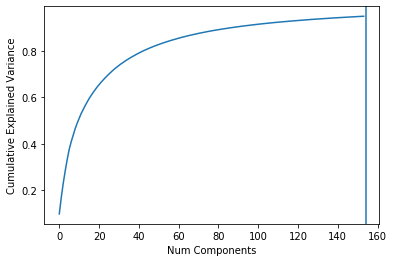

In [0]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Num Components')
plt.ylabel('Cumulative Explained Variance')
plt.axvline(x=154)

## 3: Random Forest Classifier w/PCA

In [0]:
#now let's see how the RFR does using reduced dimensions
rf_pca_1 = RandomForestClassifier(
                                  bootstrap=True,
                                  n_estimators=10,
                                  max_features=12,
                                  random_state=RANDOM_SEED,
                                 )

#time the fitting and evaluation of the model
#example of how not to do it
start = datetime.now()
rf_pca_1.fit(X_train_test_pca[:42000], y_train)
rf_pca_1_pred = rf_pca_1.predict(X_train_test_pca[:28000,])
end = datetime.now()

time_results = time_results.append({'Classifier' : 'PCA + RFC',
                                    'Time to Fit' : end-start},
                                    sort=False,
                                    ignore_index=True)

print(end-start)

0:00:07.380415


In [0]:
# now output the predictions
pred_output("rf_pca_1_predictions.csv", rf_pca_1_pred)

Oh no! We broke the cardinal rule of model-building: never expose your testing set! When we fit the PCA model, we used the entire test/train set as one. This is a huge misstep. Let's fix it now.

## 5: Modified RFC w/PCA

In [0]:
# we want to use ONLY the training set to do dimension reduction
# and also to train the RFC

# because we want the train and test set to have the same # of components
# just set the n manually
pca_2 = PCA(
           n_components=154,
           random_state=RANDOM_SEED
          )

#use the original training set to run PCA
X_train_pca_2 = pca_2.fit_transform(X_train)
#and also do it separately on the test set.
X_test_pca_2 = pca_2.fit_transform(X_test)

In [0]:
#now let's see how the RFR does using reduced dimensions
rf_pca_2 = RandomForestClassifier(
                                  bootstrap=True,
                                  n_estimators=10,
                                  max_features=12,
                                  random_state=RANDOM_SEED,
                                 )

#fit the rfc and evaluate
rf_pca_2.fit(X_train_pca_2, y_train)
rf_pca_2_pred = rf_pca_2.predict(X_test_pca_2)

In [0]:
#and output the results to csv
pred_output("rf_pca_2_predictions.csv", rf_pca_2_pred)

# Conclusion


---



In [0]:
display(time_results)

,Classifier,Time to Fit
0,RFC,00:00:04.395318
1,PCA,00:00:16.539859
2,PCA + RFC,00:00:07.380415


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:253: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  data = data.fillna(fillna)


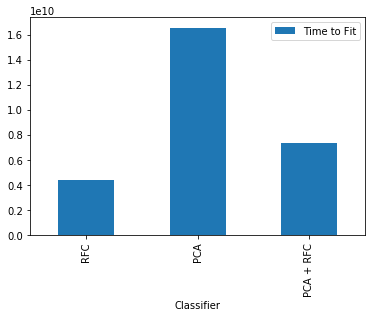

In [0]:
ax = time_results.plot.bar(x='Classifier', y='Time to Fit')

Recommendation is to implement an RFC model without any PCA prior, as perfoming PCA adds an unacceptable amount of time to model training without contributing to model performance score.